Starting this with a lookback of the teams that have won the whole thing 

In [22]:
import pandas as pd
import numpy as np

# Sample data creation for demonstration.
# Assuming the real CSV file is named 'basketball_games.csv' and contains the mentioned columns.
data = pd.read_csv('MNCAATourneyDetailedResults.csv')
# Creating a DataFrame from the sample data
df = pd.DataFrame(data)

# Filtering for seasons greater than 2010
filtered_df = df[df['Season'] > 2013]

# Finding the WTeamID with the maximum DayNum for each distinct Season
result_df = filtered_df.loc[filtered_df.groupby('Season')['DayNum'].idxmax(), ['Season', 'DayNum', 'WTeamID']]

result_df


,Season,DayNum,WTeamID
779,2014,154,1163
846,2015,154,1181
913,2016,154,1437
980,2017,154,1314
1047,2018,154,1437
1114,2019,154,1438
1180,2021,154,1124
1247,2022,154,1242
1314,2023,154,1163


In [23]:
conf_df = pd.read_csv('MconferenceTourneyGames.csv')
# conf_df =  conf_df[conf_df['ConfAbbrev'] == "big_east"]
conf_df_filtered = conf_df[conf_df['Season'] > 2005]


unique_confs = conf_df_filtered[['Season', 'ConfAbbrev']].drop_duplicates()

# For each unique season and conference pair, find the champion, runner-up, semifinalists, and quarterfinalists.
def tournament_details(row, df):
    season = row['Season']
    conf = row['ConfAbbrev']
    conf_games = df[(df['Season'] == season) & (df['ConfAbbrev'] == conf)]
    max_day = conf_games['DayNum'].max()
    champ_game = conf_games[conf_games['DayNum'] == max_day]
    champion = champ_game['WTeamID'].values[0]
    runner_up = champ_game['LTeamID'].values[0]
    semifinal_day = max_day - 1
    quarterfinal_day = max_day - 2
    semifinalists = conf_games[conf_games['DayNum'] == semifinal_day]['LTeamID'].tolist()
    quarterfinalists = conf_games[conf_games['DayNum'] == quarterfinal_day]['LTeamID'].tolist()
    return pd.Series([champion, runner_up, semifinalists, quarterfinalists])

# Apply the function to each unique conference-season pair
unique_confs[['Champion', 'RunnerUp', 'Semifinalists', 'Quarterfinalists']] = unique_confs.apply(lambda row: tournament_details(row, conf_df_filtered), axis=1)

# Merge this tournament detail with the main result DataFrame on Season
final_df_enhanced = pd.merge(result_df, unique_confs, on=['Season'], how='left')

final_df_enhanced


,Season,DayNum,WTeamID,ConfAbbrev,Champion,RunnerUp,Semifinalists,Quarterfinalists
0,2014,154,1163,a_sun,1273,1195,[],[]
1,2014,154,1163,a_ten,1386,1433,"[1382, 1203]","[1269, 1387, 1173, 1350]"
2,2014,154,1163,aac,1257,1163,"[1153, 1222]","[1416, 1272, 1374, 1353]"
3,2014,154,1163,acc,1438,1181,"[1301, 1338]","[1155, 1393, 1314, 1199]"
4,2014,154,1163,aec,1107,1392,[],[]
...,...,...,...,...,...,...,...,...
279,2023,154,1163,summit,1331,1295,"[1355, 1472]","[1377, 1442]"
280,2023,154,1163,sun_belt,1418,1375,"[1241, 1402]","[1407, 1379, 1267, 1204]"
281,2023,154,1163,swac,1411,1212,"[1238, 1105]","[1380, 1341]"
282,2023,154,1163,wac,1213,1381,"[1358, 1430]","[1370, 1465, 1469, 1470]"


In [24]:
tournament_results_df = unique_confs[['Season', 'ConfAbbrev', 'Champion', 'RunnerUp', 'Semifinalists', 'Quarterfinalists']].copy()

def determine_tournament_position_v2(row):
    season = row['Season']
    team_id = row['WTeamID']
    tournament_info = tournament_results_df[tournament_results_df['Season'] == season]

    # Initialize variables
    conf = None
    position = None

    # Check for champion, runner-up, semifinalist, quarterfinalist by iterating through the rows
    for _, t_row in tournament_info.iterrows():
        # Direct match for Champion and RunnerUp
        if team_id == t_row['Champion']:
            conf = t_row['ConfAbbrev']
            position = 'Champion'
            break
        elif team_id == t_row['RunnerUp']:
            conf = t_row['ConfAbbrev']
            position = 'RunnerUp'
            break
        # Check within lists for Semifinalists and Quarterfinalists
        elif any(team_id == semi_id for semi_id in t_row['Semifinalists']):
            conf = t_row['ConfAbbrev']
            position = 'Semifinalist'
            break
        elif any(team_id == quarter_id for quarter_id in t_row['Quarterfinalists']):
            conf = t_row['ConfAbbrev']
            position = 'Quarterfinalist'
            break

    return pd.Series([conf, position])

# Re-apply the corrected function to the results dataframe
result_df[['ConfAbbrev', 'TournamentResult']] = result_df.apply(determine_tournament_position_v2, axis=1)

result_df

,Season,DayNum,WTeamID,ConfAbbrev,TournamentResult
779,2014,154,1163,aac,RunnerUp
846,2015,154,1181,acc,Semifinalist
913,2016,154,1437,big_east,RunnerUp
980,2017,154,1314,acc,Semifinalist
1047,2018,154,1437,big_east,Champion
1114,2019,154,1438,acc,Semifinalist
1180,2021,154,1124,big_twelve,Semifinalist
1247,2022,154,1242,big_twelve,Champion
1314,2023,154,1163,big_east,Semifinalist


In [25]:
df = final_df_enhanced

# Remove the 'WTeamID' and 'DayNum' columns
df.drop(columns=['WTeamID', 'DayNum'], inplace=True)

# Initialize a list to hold the new row-wise data
rows = []

# Iterate over each row in the dataframe to transform and accumulate the data
for _, row in df.iterrows():
    season, conf = row['Season'], row['ConfAbbrev']
    # Champion
    rows.append([season, conf, 'Champion', row['Champion']])
    # RunnerUp
    rows.append([season, conf, 'RunnerUp', row['RunnerUp']])
    # Semifinalists
    for team in row['Semifinalists']:
        rows.append([season, conf, 'Semifinalist', team])
    # Quarterfinalists
    for team in row['Quarterfinalists']:
        rows.append([season, conf, 'Quarterfinalist', team])

# Create a new DataFrame from the rows list
df_transformed = pd.DataFrame(rows, columns=['Season', 'ConfAbbrev', 'ConfTournamentPlace', 'TeamID'])

df_transformed.head(200)

,Season,ConfAbbrev,ConfTournamentPlace,TeamID
0,2014,a_sun,Champion,1273
1,2014,a_sun,RunnerUp,1195
2,2014,a_ten,Champion,1386
3,2014,a_ten,RunnerUp,1433
4,2014,a_ten,Semifinalist,1382
...,...,...,...,...
195,2014,wcc,Champion,1211
196,2014,wcc,RunnerUp,1140
197,2014,wcc,Semifinalist,1362
198,2014,wcc,Semifinalist,1388


In [26]:
games_df = data

team_season_games = games_df.groupby(['Season', 'WTeamID']).size().reset_index(name='Wins').rename(columns={'WTeamID': 'TeamID'})
team_season_losses = games_df.groupby(['Season', 'LTeamID']).size().reset_index(name='Losses').rename(columns={'LTeamID': 'TeamID'})

# Merge the win and loss counts on Season and TeamID, filling missing values with 0
team_games_combined = pd.merge(team_season_games, team_season_losses, on=['Season', 'TeamID'], how='outer').fillna(0)

# Calculate total games played
team_games_combined['GamesPlayed'] = team_games_combined['Wins'] + team_games_combined['Losses']

# Drop the Wins and Losses columns as they are not required for the final output
team_games_combined.drop(columns=['Wins', 'Losses'], inplace=True)

team_games_combined

,Season,TeamID,GamesPlayed
0,2003,1112,4.0
1,2003,1113,2.0
2,2003,1120,3.0
3,2003,1139,3.0
4,2003,1141,2.0
...,...,...,...
1330,2023,1429,1.0
1331,2023,1433,1.0
1332,2023,1436,1.0
1333,2023,1438,1.0


In [27]:
conf_tourney_competitors_ncaa_tourney_results = pd.merge(df_transformed,team_games_combined, on=['Season', 'TeamID'], how='inner')
print(conf_tourney_competitors_ncaa_tourney_results )

     Season ConfAbbrev ConfTournamentPlace  TeamID  GamesPlayed
0      2014      a_sun            Champion    1273          2.0
1      2014      a_ten            Champion    1386          1.0
2      2014      a_ten            RunnerUp    1433          1.0
3      2014      a_ten        Semifinalist    1203          1.0
4      2014      a_ten     Quarterfinalist    1269          1.0
..      ...        ...                 ...     ...          ...
572    2023   sun_belt            Champion    1418          1.0
573    2023       swac            Champion    1411          1.0
574    2023        wac            Champion    1213          1.0
575    2023        wcc            Champion    1211          4.0
576    2023        wcc            RunnerUp    1388          2.0

[577 rows x 5 columns]


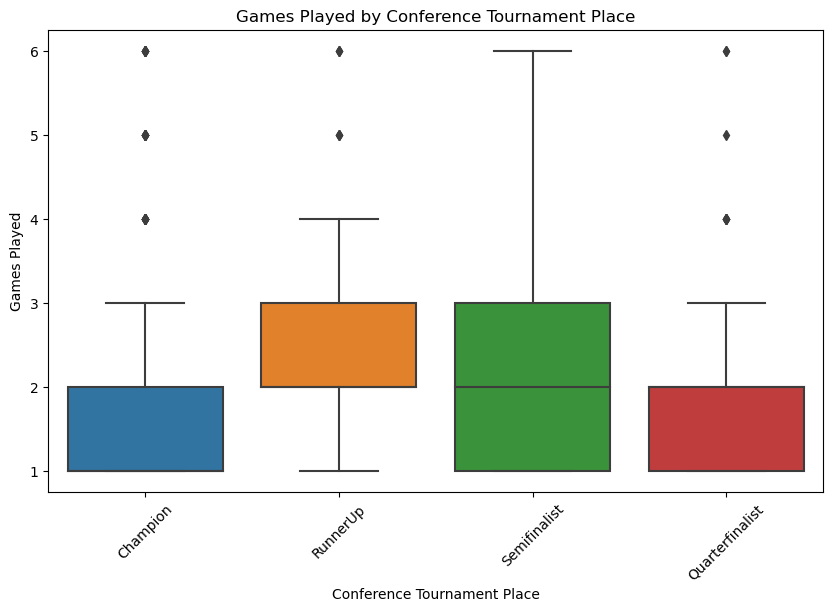

In [28]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=conf_tourney_competitors_ncaa_tourney_results, x='ConfTournamentPlace', y='GamesPlayed')
plt.title('Games Played by Conference Tournament Place')
plt.xlabel('Conference Tournament Place')
plt.ylabel('Games Played')
plt.xticks(rotation=45)
plt.show()

In [29]:
teamSeeds_df = pd.read_csv('MNCAATourneySeeds.csv')
teamSeeds_df['SeedNum'] = teamSeeds_df['Seed'].str.extract('(\d+)').astype(int)

# Filter the DataFrame for rows where the seed number is less than 8
teamSeeds_df = teamSeeds_df[teamSeeds_df['SeedNum'] < 7]

# Drop the temporary SeedNum column if no longer needed
# teamSeeds_df = filtered_df.drop(columns=['SeedNum'])

filtered_df
print(teamSeeds_df)



      Season Seed  TeamID  SeedNum
0       1985  W01    1207        1
1       1985  W02    1210        2
2       1985  W03    1228        3
3       1985  W04    1260        4
4       1985  W05    1374        5
...      ...  ...     ...      ...
2474    2023  Z02    1417        2
2475    2023  Z03    1211        3
2476    2023  Z04    1163        4
2477    2023  Z05    1388        5
2478    2023  Z06    1395        6

[912 rows x 4 columns]


In [30]:
top8conftourneyResults = pd.merge(conf_tourney_competitors_ncaa_tourney_results,teamSeeds_df, on=['Season', 'TeamID'], how='inner')
print(top8conftourneyResults)

     Season ConfAbbrev ConfTournamentPlace  TeamID  GamesPlayed Seed  SeedNum
0      2014      a_ten            RunnerUp    1433          1.0  X05        5
1      2014      a_ten     Quarterfinalist    1269          1.0  Y06        6
2      2014      a_ten     Quarterfinalist    1387          2.0  Y05        5
3      2014        aac            Champion    1257          3.0  Y04        4
4      2014        aac        Semifinalist    1153          1.0  W05        5
..      ...        ...                 ...     ...          ...  ...      ...
207    2023        sec            Champion    1104          3.0  X01        1
208    2023        sec     Quarterfinalist    1397          3.0  W04        4
209    2023        sec     Quarterfinalist    1246          2.0  W06        6
210    2023        wcc            Champion    1211          4.0  Z03        3
211    2023        wcc            RunnerUp    1388          2.0  Z05        5

[212 rows x 7 columns]


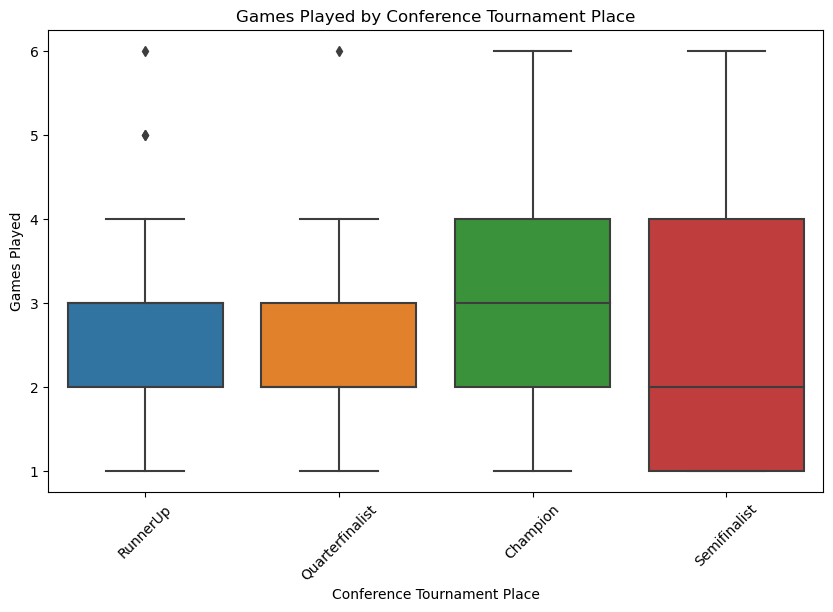

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=top8conftourneyResults, x='ConfTournamentPlace', y='GamesPlayed')
plt.title('Games Played by Conference Tournament Place')
plt.xlabel('Conference Tournament Place')
plt.ylabel('Games Played')
plt.xticks(rotation=45)
plt.show()

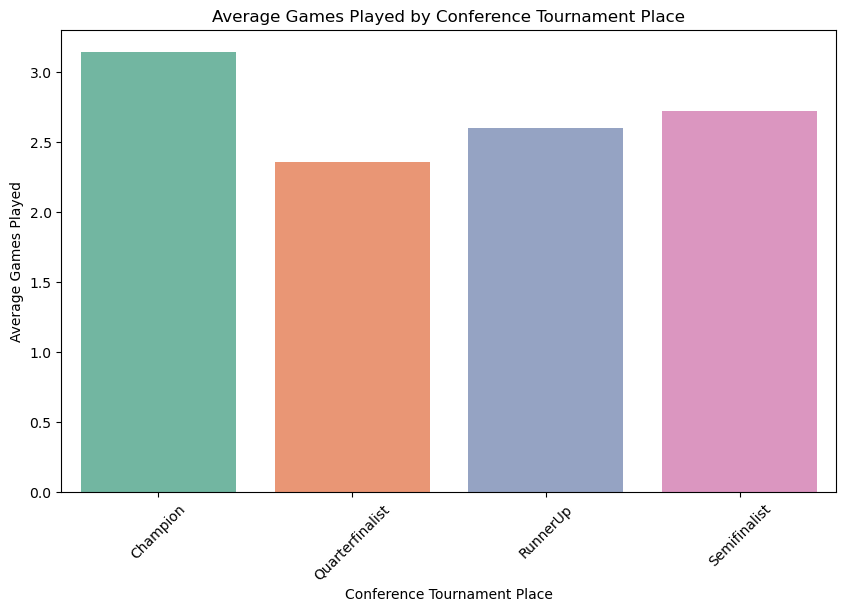

In [32]:
avg_games_played = top8conftourneyResults.groupby('ConfTournamentPlace')['GamesPlayed'].mean().reset_index()

# Plotting the average games played
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_games_played, x='ConfTournamentPlace', y='GamesPlayed', palette="Set2")
plt.title('Average Games Played by Conference Tournament Place')
plt.xlabel('Conference Tournament Place')
plt.ylabel('Average Games Played')
plt.xticks(rotation=45)
plt.show()

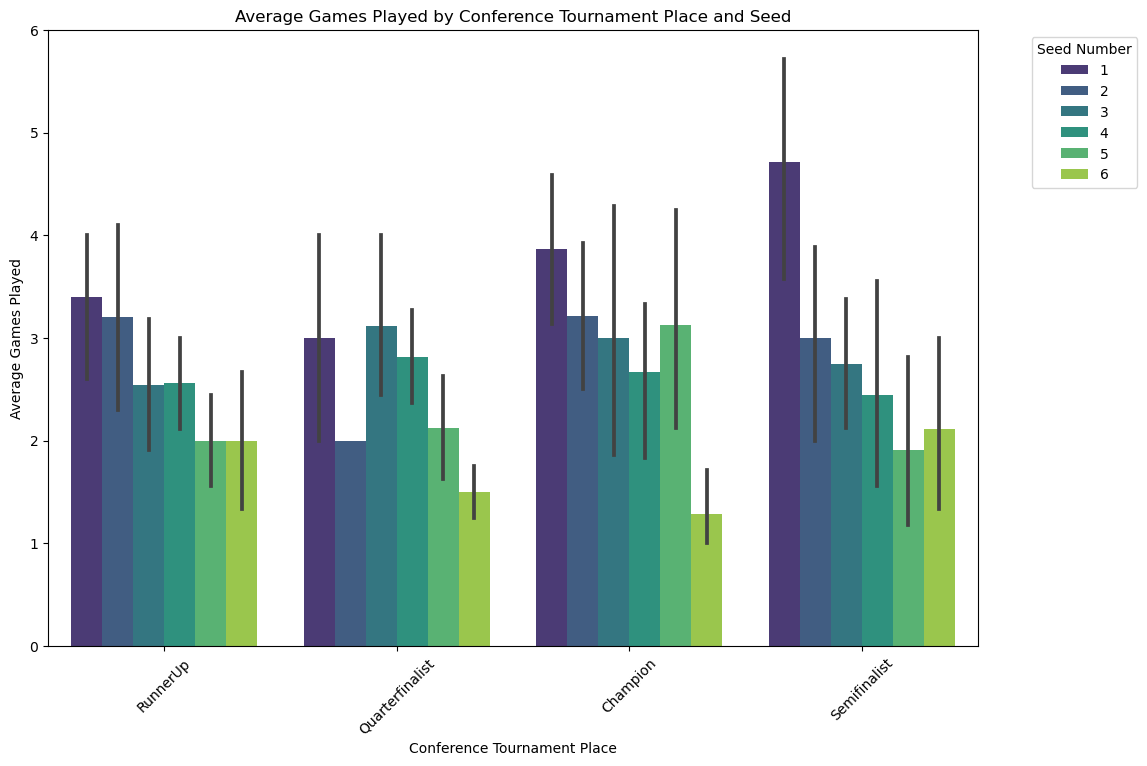

In [33]:
plt.figure(figsize=(12, 8))
sns.barplot(data=top8conftourneyResults, x='ConfTournamentPlace', y='GamesPlayed', hue='SeedNum', palette="viridis")
plt.title('Average Games Played by Conference Tournament Place and Seed')
plt.xlabel('Conference Tournament Place')
plt.ylabel('Average Games Played')
plt.legend(title='Seed Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


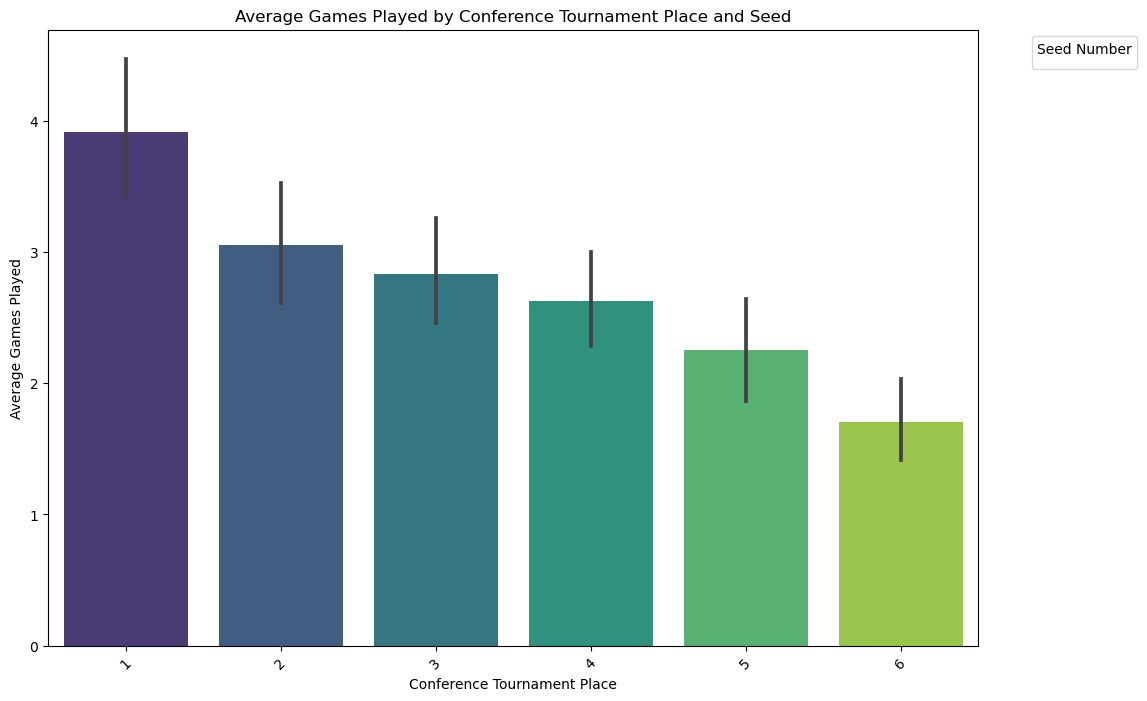

In [34]:
plt.figure(figsize=(12, 8))
sns.barplot(data=top8conftourneyResults,  y='GamesPlayed', x='SeedNum', palette="viridis")
plt.title('Average Games Played by Conference Tournament Place and Seed')
plt.xlabel('Conference Tournament Place')
plt.ylabel('Average Games Played')
plt.legend(title='Seed Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

In [35]:
import pandas as pd
import plotly.graph_objects as go

# Mock dataset similar to the described one

df = top8conftourneyResults

# For simplicity, we'll use the SeedNum directly and assume it's related to GamesPlayed somehow
# We'll also assume an incremental build-up of games played for the waterfall effect
df_grouped = df.groupby('SeedNum')['GamesPlayed'].mean().reset_index().sort_values(by='SeedNum')

# Assuming 'relative' for all and 'total' at the end for the plotly example
measures = ['relative'] * len(df_grouped)
x_values = df_grouped['SeedNum'].astype(str).tolist()
y_values = df_grouped['GamesPlayed'].tolist()

# Adding a 'total' measure at the end
measures[-1] = 'total'
y_values.append(sum(y_values))  # This would be the total at the end

# Text for each bar
text_values = [f"+{y}" for y in y_values[:-1]] + ["Total"]

fig = go.Figure(go.Waterfall(
    name="Average Games Played", orientation="v",
    measure=measures,
    x=x_values,
    textposition="outside",
    text=text_values,
    y=y_values,
    connector={"line": {"color": "rgb(63, 63, 63)"}},
))

fig.update_layout(
        title="Average Games Played by Seed Number",
        xaxis_title="Seed Number",
        yaxis_title="Games Played",
        showlegend=True
)

fig.show()



In [36]:
import plotly.graph_objects as go
import numpy as np
# Assuming 'df' is your DataFrame with detailed game records, including SeedNum
# Calculate the average games played for each SeedNum
avg_games_played_by_seed = df.groupby('SeedNum')['GamesPlayed'].mean().reset_index()

# Sort the DataFrame by SeedNum to ensure the order is correct
avg_games_played_by_seed = avg_games_played_by_seed.sort_values(by='SeedNum')

# Calculate the deltas for the waterfall chart
# For the waterfall chart, the first delta is the average games played by the 1 seed
# Subsequent deltas are the changes from one seed to the next
deltas = np.diff(avg_games_played_by_seed['GamesPlayed'], prepend=avg_games_played_by_seed['GamesPlayed'].iloc[0])

# Adjust the measures array for the waterfall chart
measures = ['relative'] * len(deltas)
measures[0] = 'absolute'  # The first value is the starting point (absolute)

# Text for the annotations
text_values = [f"{delta:.2f}" if i != 0 else f"{avg_games_played_by_seed['GamesPlayed'].iloc[0]:.2f}" for i, delta in enumerate(deltas)]

# Create the waterfall chart
fig = go.Figure(go.Waterfall(
    name="Average Games Played",
    orientation="v",
    measure=measures,
    x=avg_games_played_by_seed['SeedNum'].astype(str).tolist(),
    textposition="outside",
    text=text_values,
    y=deltas,
    connector={"line":{"color":"rgb(63, 63, 63)"}},
))

fig.update_layout(
    title="Delta of Average Games Played by Seed Number",
    xaxis_title="Seed Number",
    yaxis_title="Delta in Average Games Played",
    showlegend=True
)

fig.show()

